In [1]:
!pip install neurokit2
import pandas as pd
import os
import numpy as np
import neurokit2 as nk

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading the CSV file

In [2]:
path = '/kaggle/input/ecg-file/045_0-500000_corrected.csv'
df = pd.read_csv(path)
# df.head()

In [3]:
peak = df[df['Label']==1]
not_peak = df[df['Label']==0]

print("Peak : {}".format(len(peak)))
print("Not Peak : {}".format(len(not_peak)))

Peak : 644
Not Peak : 499356


# Calculating Sampling Rate

In [4]:
total_data_points = len(df)  # Total number of data points
total_duration = df['Time'].iloc[-1] - df['Time'].iloc[0]  # Total duration in seconds

# Calculate the sampling rate
sampling_rate = total_data_points / total_duration
print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 4807.692307692308 Hz


# Prediction with Neurokit

In [5]:
raw_array = df['Raw'].to_numpy()
sig, inf = nk.ecg_process(raw_array, sampling_rate=sampling_rate)

In [6]:
act_r = df['Label']
r_predicted = sig['ECG_R_Peaks']
# r_predicted.value_counts()

# Evaluating the prediction

In [7]:
from sklearn.metrics import classification_report
print(classification_report(act_r, r_predicted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    499356
         1.0       0.00      0.00      0.00       644

    accuracy                           1.00    500000
   macro avg       0.50      0.50      0.50    500000
weighted avg       1.00      1.00      1.00    500000



In [8]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef
roc_auc = roc_auc_score(act_r, r_predicted)
mcc_score = matthews_corrcoef(act_r, r_predicted)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.49997897291711724
Matthews Correlation Coefficient: -0.00023274028564834962


# Neurokit with 1000Hz sampling rate

In [9]:
signal, info = nk.ecg_process(raw_array, sampling_rate=1000)
signal.head()

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-161.521893,-50.105353,77.965294,0.796639,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-178.571427,-51.974266,77.965294,0.796639,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-190.236900,-53.757939,77.965294,0.796639,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-188.442211,-55.422727,77.965294,0.796639,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-189.339555,-56.991069,77.965294,0.796639,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [10]:
pred_r = signal['ECG_R_Peaks']

In [11]:
data = df.copy()
data['pred'] = signal['ECG_R_Peaks']
# data['clean_volt'] = signal['ECG_Clean']
# data

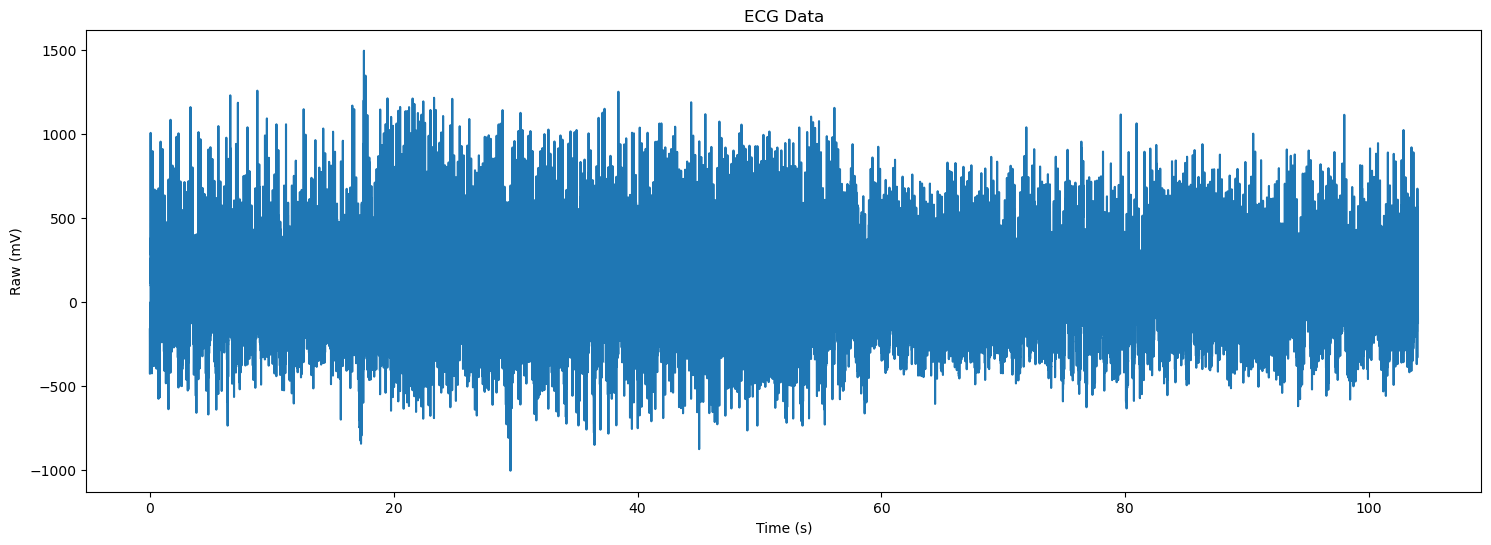

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
plt.plot(df['Time'], df['Raw'], label='ECG Signal')
# plt.scatter(df['Time'][df['Label'] == 1], df['Raw'][df['Label'] == 1], c='red', label='Peak')
plt.xlabel(r'Time (s)')
plt.ylabel('Raw (mV)')
plt.title("ECG Data")
plt.show()

# Actual vs Predicted Peaks

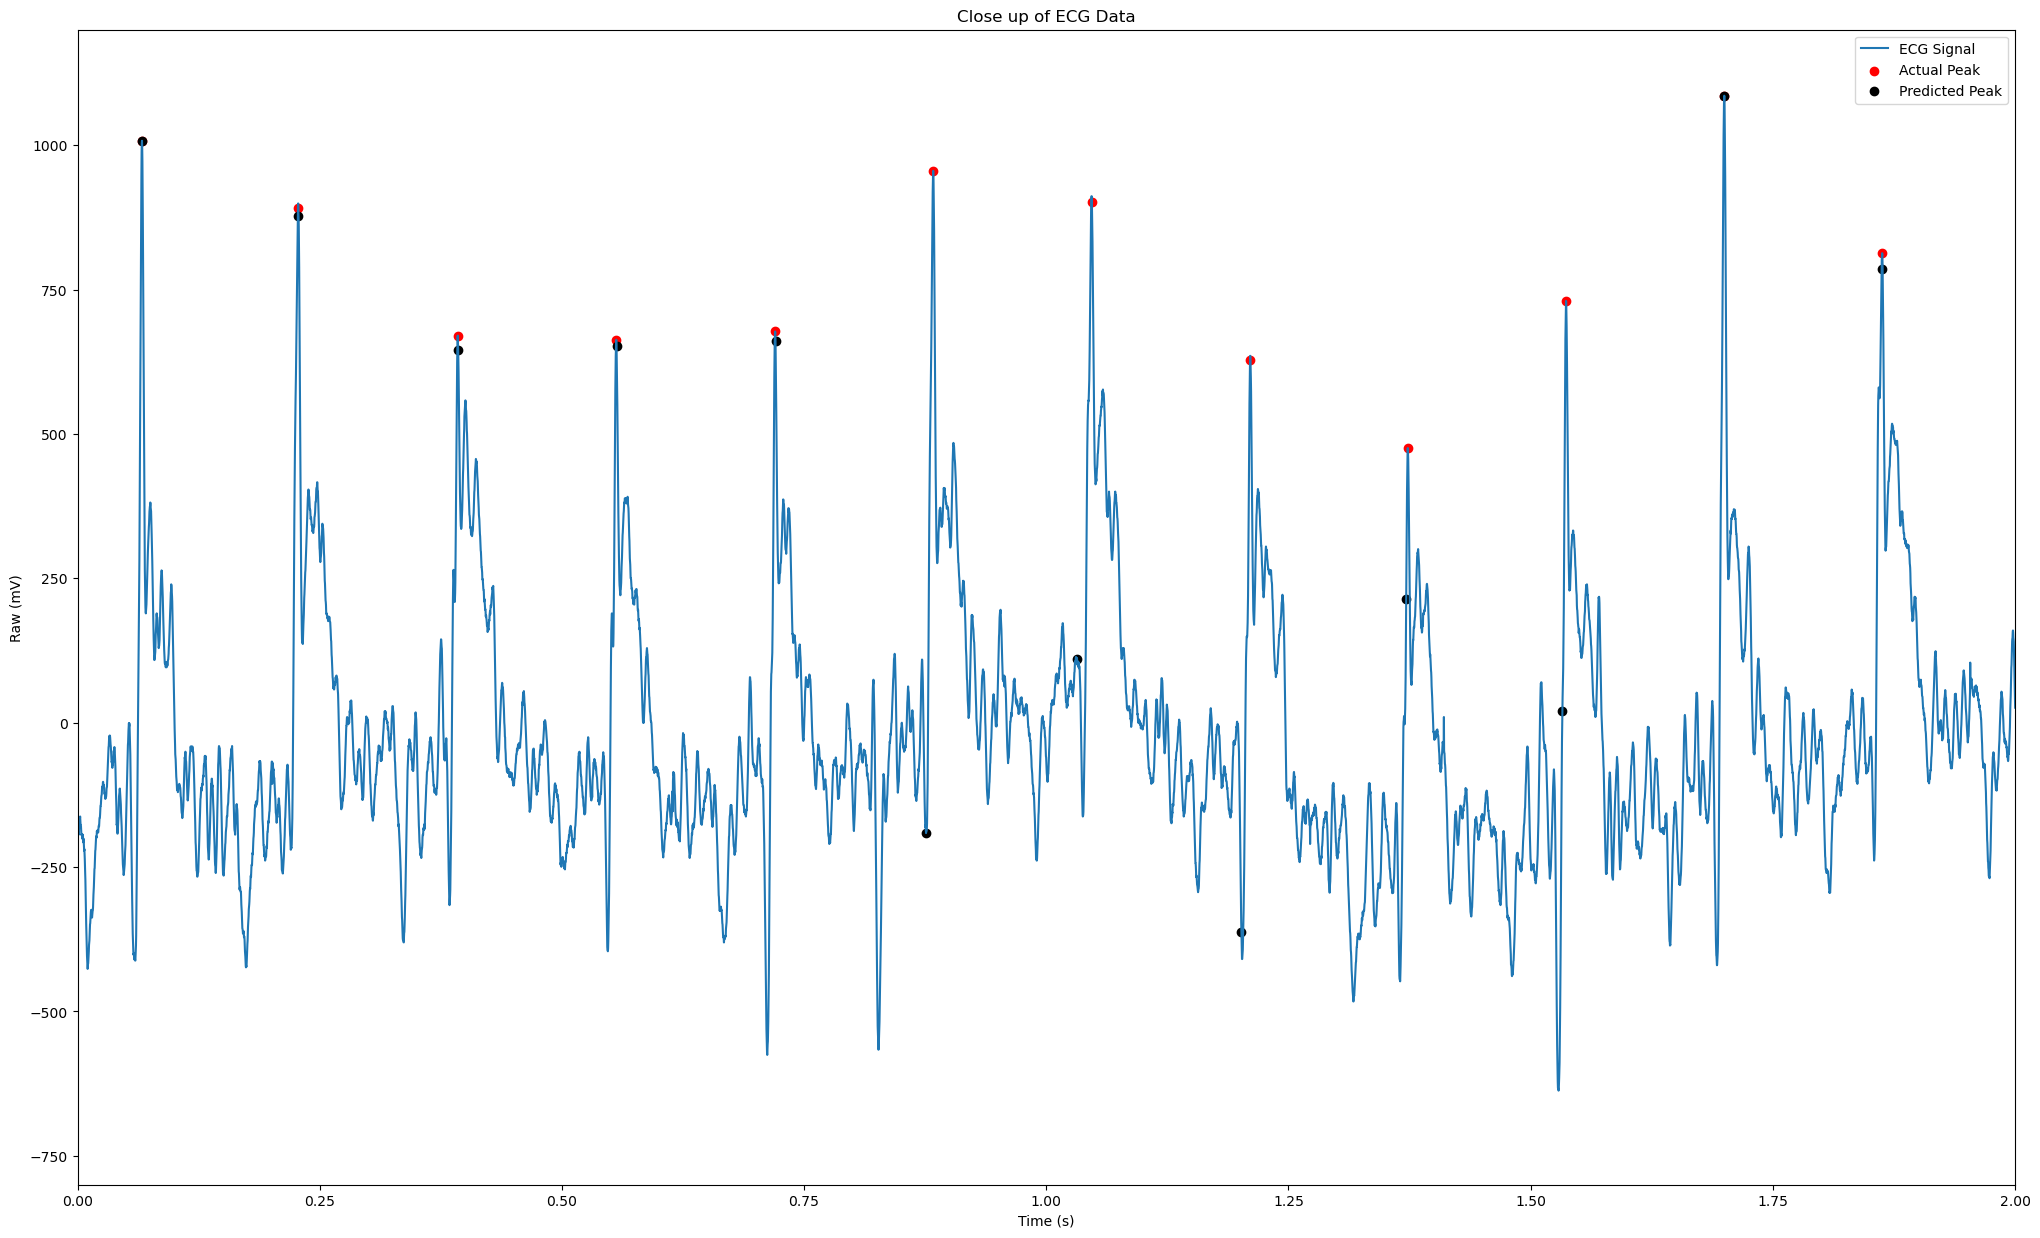

In [13]:
plt.figure(figsize=(25, 15))
plt.plot(df['Time'], df['Raw'], label='ECG Signal')
plt.scatter(df['Time'][df['Label'] == 1], df['Raw'][df['Label'] == 1], c='red', label='Actual Peak')
plt.scatter(data['Time'][data['pred'] == 1], data['Raw'][data['pred'] == 1], c='black', label='Predicted Peak')
plt.xlabel('Time (s)')
plt.ylabel('Raw (mV)')
plt.xlim(0, 2)

# Set the y-axis limits to expand the range
plt.ylim(-800,1200 )  # Adjust the values as needed
# plt.yticks(range(-800, 1201, 100))
plt.title("Close up of ECG Data")
plt.legend()
plt.show()

In [14]:
#since the neurokit predicts the correct R peaks at a sampling rate of 1000Hz with small variations in the voltage
# we are defining a threshold to evaluate the model
th = [1,2,3]
for i in range(len(act_r)):
    if pred_r[i] == act_r[i]:
        continue
    else:
        for x in th:
            if (pred_r[i]== act_r[i+x]) or (pred_r[i] == act_r[i-x]):
                pred_r[i] = act_r[i]
            else:
                continue

/tmp/ipykernel_717/1205970739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_r[i] = act_r[i]


# Evaluation metrices

In [15]:
from sklearn.metrics import classification_report
print(classification_report(act_r, pred_r))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    499356
         1.0       0.75      1.00      0.85       644

    accuracy                           1.00    500000
   macro avg       0.87      1.00      0.93    500000
weighted avg       1.00      1.00      1.00    500000



In [16]:
from sklearn.metrics import roc_curve, auc
roc_auc = roc_auc_score(act_r, pred_r)
mcc_score = matthews_corrcoef(act_r, pred_r)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.9997797162745616
Matthews Correlation Coefficient: 0.8631581456757141


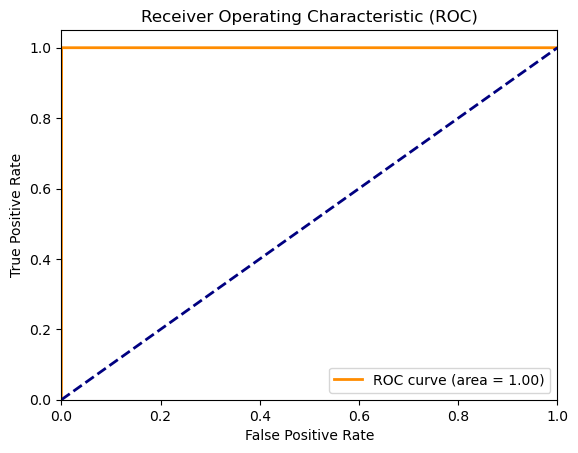

In [17]:
fpr, tpr, thresholds = roc_curve(act_r, pred_r)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

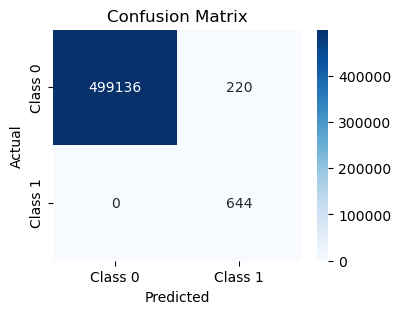

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(act_r, pred_r)

# Define class labels (modify if needed)
class_labels = ['Class 0', 'Class 1']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
df['Predicted Label'] = pred_r

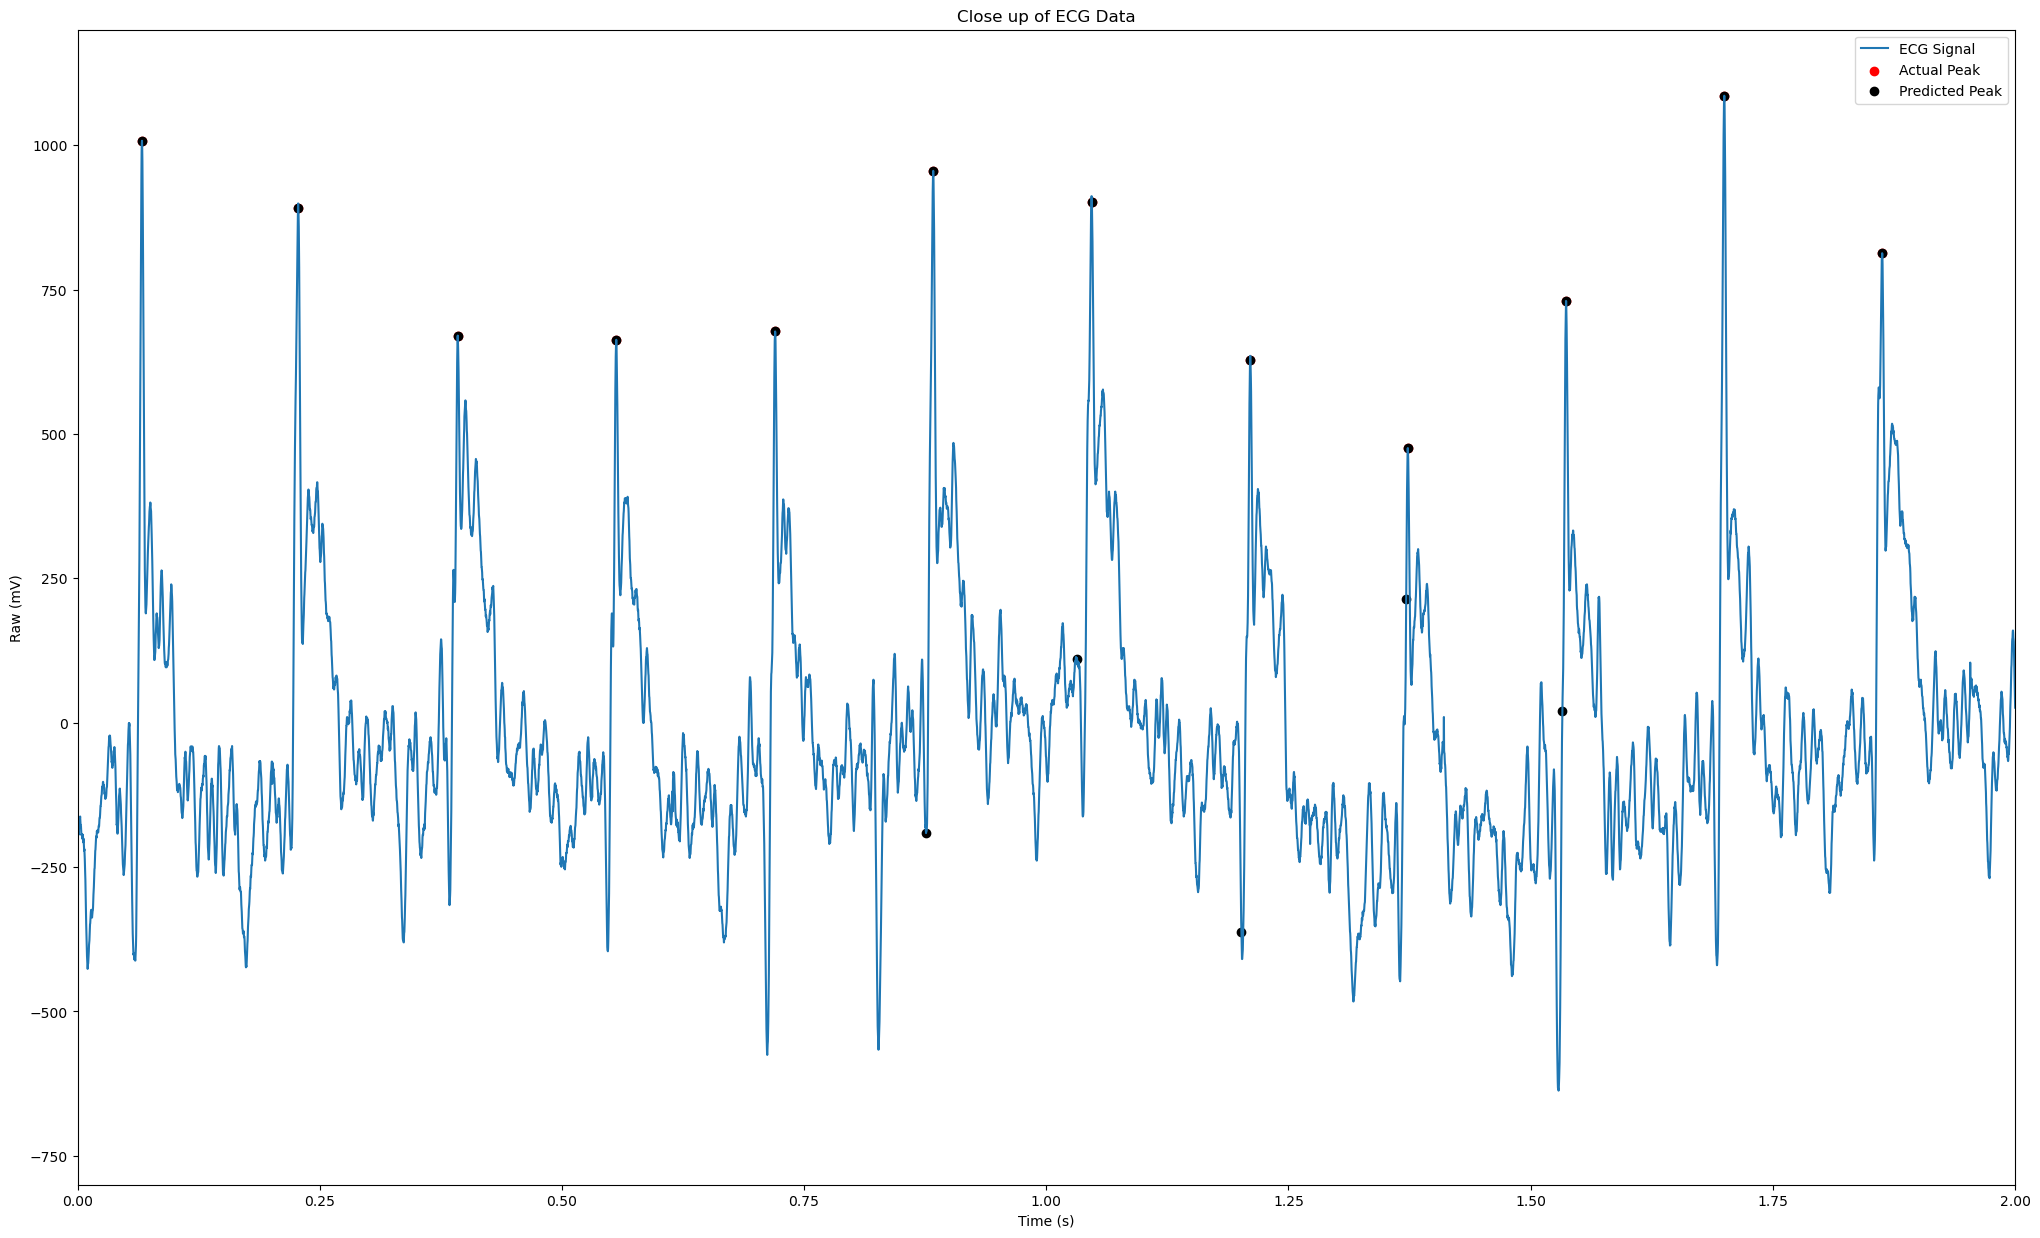

In [20]:
plt.figure(figsize=(25, 15))
plt.plot(df['Time'], df['Raw'], label='ECG Signal')
plt.scatter(df['Time'][df['Label'] == 1], df['Raw'][df['Label'] == 1], c='red', label='Actual Peak')
plt.scatter(df['Time'][df['Predicted Label'] == 1], df['Raw'][df['Predicted Label'] == 1], c='black', label='Predicted Peak')
plt.xlabel('Time (s)')
plt.ylabel('Raw (mV)')
plt.xlim(0, 2)

# Set the y-axis limits to expand the range
plt.ylim(-800,1200 )  # Adjust the values as needed
# plt.yticks(range(-800, 1201, 100))
plt.title("Close up of ECG Data")
plt.legend()
plt.show()

# Actual Heart Rate

In [21]:
r_peak_times = df[df['Label'] == 1]['Time']
time_intervals = r_peak_times.diff().dropna()
average_time_interval = time_intervals.mean() 
heart_rate_bpm = 60.0 / average_time_interval
print("Heart rate (BPM):", heart_rate_bpm)

Heart rate (BPM): 371.36930278800975


# Predicted Heart Rate

In [22]:
r_peak_times_pred = df[df['Predicted Label'] == 1]['Time']
time_intervals_pred = r_peak_times_pred.diff().dropna()
average_time_interval_pred = time_intervals_pred.mean() 
heart_rate_bpm_pred = 60.0 / average_time_interval_pred
print("Predicted Heart rate (BPM):", heart_rate_bpm_pred)

Predicted Heart rate (BPM): 498.43189472169894
